In [1]:
import investpy as ip
import pandas as pd
import time
import yfinance as yf
from datetime import datetime
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import backtester

# Getting the data #

In [2]:
def get_interest_rates(start_date, end_date):

    data = ip.economic_calendar(countries=["united states"], categories=["central_banks"], from_date=start_date, to_date=end_date)
    data = data[data["event"].str.contains("Interest Rate")]
    data = data[~data["event"].str.contains("Projection")]
    data["date"] = pd.to_datetime(data["date"], format='%d/%m/%Y')
    data['value'] = data.actual
    data['type'] = "Interest Rate"
    data.value = data.value.str.replace('%', '')
    return data

In [3]:
def get_nfp(start_date, end_date):

    data = ip.economic_calendar(countries=["united states"], categories=["employment"], from_date=start_date, to_date=end_date)
    data = data[data["event"].str.contains("Nonfarm")]
    data = data[~data["event"].str.contains("Private|ADP")]
    data["date"] = pd.to_datetime(data["date"], format='%d/%m/%Y')
    data['value'] = data.actual
    data['type'] = "NFP"
    data.value = data.value.str.replace('K', '')
    return data

In [4]:
def get_inflation(start_date, end_date):

    data = ip.economic_calendar(countries=["united states"], categories=["inflation"], from_date=start_date, to_date=end_date)
    data = data[data["event"].str.contains("CPI (YoY)", regex=False)]
    data = data[~data["event"].str.contains("Core")]
    data["date"] = pd.to_datetime(data["date"], format='%d/%m/%Y')
    data['value'] = data.actual
    data['type'] = "CPI"
    data.value = data.value.str.replace('%', '')
    return data

In [5]:
def get_pmi(start_date, end_date):
        
    data = ip.economic_calendar(countries=["united states"], categories=["economic_activity"], from_date=start_date, to_date=end_date)
    data = data[data["event"].str.contains("ISM Manufacturing")]
    data['month'] = pd.to_datetime(data['date'], format='%d/%m/%Y').dt.to_period('M')
    data['value'] = data.actual
    data['type'] = "PMI"
    return data.groupby('month').head(1).drop('month', axis=1)

In [6]:
def get_unemployment(start_date, end_date):
    
    data = ip.economic_calendar(countries=["united states"], categories=["employment"], from_date=start_date, to_date=end_date)
    data = data[data["event"].str.contains("Unemployment")]
    data = data[~data["event"].str.contains("U6")]
    data["date"] = pd.to_datetime(data["date"], format='%d/%m/%Y')
    data['value'] = data.actual
    data['type'] = "Unemployment"
    data.value = data.value.str.replace('%', '')
    return data    

In [7]:
def get_gpr(start_date, end_date):
    data = pd.read_excel("https://www.matteoiacoviello.com/gpr_files/data_gpr_daily_recent.xls")
    data = data[["GPRD", "date"]]
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    data = data[(data["date"] >= start_date) & (data["date"] <= end_date)]
    data['value'] = data.GPRD
    data.value = pd.to_numeric(data.value, errors="coerce").round(0)
    data['type'] = "GPRD"
    return data

In [3]:
def get_market_data(start_date, end_date):
    
    start_date = datetime.strptime(start_date, "%d/%m/%Y").strftime("%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%d/%m/%Y").strftime("%Y-%m-%d")
    
    tickers = {
        "^GSPC": "SP500",
        "ZN=F": "10Y_Bond",
        "DX-Y.NYB": "USD",
        "GC=F": "Gold",
        "CL=F": "Oil"
    }
    
    result = pd.DataFrame()
    
    for ticker, name in tickers.items():
        data = yf.Ticker(ticker).history(start=start_date, end=end_date)["Close"]
        result[name] = data
        
    return result

# Combining the data #

In [4]:
def combine_and_sort_data(start_date, end_date):
    # Get all datasets
    '''
    interest_rates = get_interest_rates(start_date, end_date)
    nfp = get_nfp(start_date, end_date)
    inflation = get_inflation(start_date, end_date)
    time.sleep(360)
    pmi = get_pmi(start_date, end_date)
    unemployment = get_unemployment(start_date, end_date)
    gpr = get_gpr(start_date, end_date)
    
    combined_data = pd.concat([interest_rates, nfp, inflation, pmi, unemployment, gpr])
   
    combined_data = 
    combined_data['date'] = pd.to_datetime(combined_data['date']).dt.strftime('%Y-%m-%d')
    combined_data = combined_data[["date", "value", "type"]]
    combined_data.to_excel("data.xlsx")
     '''

    combined_data = pd.read_excel("data.xlsx")

    combined_data['date'] = pd.to_datetime(combined_data['date'])
    combined_data.value = pd.to_numeric(combined_data.value)


    combined_data['year_month'] = combined_data['date'].dt.to_period('M')
    
    # Separate GPRD data and other indicators
    gprd_data = combined_data[combined_data['type'] == 'GPRD'].copy()
    other_data = combined_data[combined_data['type'] != 'GPRD'].copy()
    
    # Calculate monthly average for GPRD
    gprd_monthly = gprd_data.groupby(['year_month', 'type'])['value'].mean().reset_index()
    
    # Combine GPRD monthly averages with other indicators
    combined_data = pd.concat([gprd_monthly, other_data[['year_month', 'type', 'value']]])
    
    # Pivot the data to get indicator types as columns
    pivoted_data = combined_data.pivot_table(
        index='year_month',
        columns='type',
        values='value',
        aggfunc='last'  # This will take the last value for each month for other indicators
    )
    
    # Sort the index
    pivoted_data.sort_index(inplace=True)
    
    # Forward fill missing values within a 3-month window
    pivoted_data = pivoted_data.fillna(method='ffill')
    
    return pivoted_data

# Preparing dataset #

In [13]:
def categorize_market_type(prices):
    # Resample to month-end
    monthly_prices = prices.resample('ME').last()
    
    # Calculate monthly returns
    monthly_returns = monthly_prices.pct_change()
    
    # Create types DataFrame with same structure as monthly_returns
    types = pd.DataFrame(np.nan, index=monthly_prices.index, columns=monthly_prices.columns)
    
    # For each asset
    for column in monthly_returns.columns:
        # Create mask for valid data
        valid_mask = ~monthly_returns[column].isna()
        
        # Set 1 for positive returns, -1 for negative or zero returns
        types.loc[valid_mask, column] = np.where(
            monthly_returns.loc[valid_mask, column] > 0, 
            1, 
            0
        )
    
    # Format index to YYYY-MM
    types.index = types.index.strftime('%Y-%m')
    
    return types

In [6]:
def calculate_trends(df, columns, periods=[3, 6]):
    """
    Calculate moving averages and trends for specified columns over given periods.
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    columns (list): List of column names to calculate trends for
    periods (list): List of periods (in months) to calculate trends for
    
    Returns:
    pd.DataFrame: Original dataframe with added trend columns
    """
    result = df.copy()
    
    for column in columns:
        # Skip if column doesn't exist
        if column not in df.columns:
            continue
            
        # Calculate trends for different periods
        for period in periods:
            # Moving average
            ma_col = f"{column}_ma_{period}m"
            result[ma_col] = df[column].rolling(window=period).mean()
            
            # Trend (current value compared to moving average)
            trend_col = f"{column}_trend_{period}m"
            result[trend_col] = (df[column] - result[ma_col]) / result[ma_col]

    result = result.resample('M').last()
    result.index = result.index.strftime('%Y-%m')
    
    return result

In [7]:
def calculate_market_trends(prices_df, periods=[3, 6]):
    """
    Calculate market trends for asset prices.
    
    Parameters:
    prices_df (pd.DataFrame): DataFrame containing market prices
    periods (list): List of periods (in months) to calculate trends for
    
    Returns:
    pd.DataFrame: DataFrame with added trend features
    """

    # Calculate trends for all columns
    return calculate_trends(prices_df, prices_df.columns.tolist(), periods), prices_df

In [8]:
def prepare_features_with_trends(macro_data, market_data):
    """
    Prepare combined features with trends for both macro and market data.
    
    Parameters:
    macro_data (pd.DataFrame): DataFrame containing macro indicators
    market_data (pd.DataFrame): DataFrame containing market prices
    
    Returns:
    pd.DataFrame: Combined DataFrame with trend features
    """
    # Calculate trends for macro data
    macro_features = calculate_trends(
        macro_data,
        ['CPI', 'GPRD', 'Interest Rate', 'NFP', 'PMI', 'Unemployment'],
        periods=[3, 6]
    )
    
    # Calculate trends for market data
    market_features, market = calculate_market_trends(market_data, periods=[3, 6])
    
    # Combine features
    combined_features = pd.merge(
        macro_features,
        market_features,
        left_index=True,
        right_index=True,
        how='left'
    )

    combined_features = combined_features.shift(1)


    labels = categorize_market_type(market_data)

    combined_features = pd.merge(
        combined_features,
        labels,
        left_index=True,
        right_index=True,
        how='left'
    )


    combined_features = combined_features[combined_features.index >= '2003-01']

    return combined_features

# Model #

In [9]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class MarketPredictionModel:
    def __init__(self, data, target_columns, train_end_year=2018, n_splits=5):
        self.data = data.copy()
        self.target_columns = target_columns
        self.train_end_year = train_end_year
        self.n_splits = n_splits
        self.models = {}
        
        # Select features excluding only the target classification columns
        self.feature_columns = []
        for col in data.columns:
            # Skip only the exact target columns (those ending with _y)
            if col not in target_columns:
                self.feature_columns.append(col)
                
        print("Features being used:")
        for feat in sorted(self.feature_columns):
            print(f"- {feat}")
        
        # Split data into train and future test
        self.split_data()
        
    def split_data(self):
        """Split data into training and future testing sets based on year"""
        self.data.index = pd.to_datetime(self.data.index.astype(str) + '-01')
        self.train_data = self.data[self.data.index.year <= self.train_end_year]
        self.future_test_data = self.data[self.data.index.year > self.train_end_year]
        
        print(f"\nTraining data period: {self.train_data.index.min()} to {self.train_data.index.max()}")
        print(f"Future testing period: {self.future_test_data.index.min()} to {self.future_test_data.index.max()}")
        print(f"Number of features: {len(self.feature_columns)}")
        
    def prepare_features(self, data, is_training=True):
        """Prepare features ensuring no future information leakage"""
        X = data[self.feature_columns].copy()
        
        # Handle missing values without future information
        if is_training:
            # For training, we can only use past information
            X = X.fillna(method='ffill')
        else:
            # For testing, we can use the last known value from training
            last_train_values = self.train_data[self.feature_columns].iloc[-1]
            X = X.fillna(method='ffill')
            X = X.fillna(last_train_values)
        
        # Fill any remaining NAs with 0
        X = X.fillna(0)
        
        return X
    
    def train_models(self):
        """Train separate models for each target using TimeSeriesSplit"""
        X_train_full = self.prepare_features(self.train_data)
        
        tscv = TimeSeriesSplit(n_splits=self.n_splits)
        
        for target in self.target_columns:
            print(f"\nTraining model for {target}")
            y_train_full = self.train_data[target]
            
            model = XGBClassifier(
                objective='multi:softmax',
                num_class=3,
                max_depth=5,
                learning_rate=0.05,
                n_estimators=100,
                subsample=0.7,
                colsample_bytree=0.7,
                random_state=42
            )
            
            cv_scores = []
            for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full)):
                X_fold_train = X_train_full.iloc[train_idx]
                X_fold_val = X_train_full.iloc[val_idx]
                y_fold_train = y_train_full.iloc[train_idx]
                y_fold_val = y_train_full.iloc[val_idx]
                
                model.fit(X_fold_train, y_fold_train)
                
                # Evaluate on validation set
                val_pred = model.predict(X_fold_val)
                fold_score = classification_report(y_fold_val, val_pred, output_dict=True)
                cv_scores.append(fold_score['accuracy'])
                
                print(f"Fold {fold + 1} Accuracy: {fold_score['accuracy']:.3f}")
                
            print(f"Average CV Accuracy: {np.mean(cv_scores):.3f} (+/- {np.std(cv_scores):.3f})")
            
            # Train final model on all training data
            model.fit(X_train_full, y_train_full)
            self.models[target] = model
            
            # Plot feature importance
            self.plot_feature_importance(target)
    
    def evaluate_future_performance(self):
        """Evaluate models on the future test set"""
        X_test = self.prepare_features(self.future_test_data, is_training=False)
        
        results = {}
        for target in self.target_columns:
            model = self.models[target]
            y_test = self.future_test_data[target]
            
            predictions = model.predict(X_test)
            
            results[target] = {
                'predictions': predictions,
                'actual': y_test,
                'report': classification_report(y_test, predictions, output_dict=True)
            }
            
            print(f"\nFuture Test Results for {target}:")
            print(classification_report(y_test, predictions))
            
            self.plot_confusion_matrix(y_test, predictions, target)
            
        return results
    
    def plot_feature_importance(self, target):
        """Plot feature importance for a specific target"""
        importance = self.models[target].feature_importances_
        features = list(self.feature_columns)
        
        importance_pairs = list(zip(features, importance))
        sorted_pairs = sorted(importance_pairs, key=lambda x: x[1], reverse=True)
        top_features = sorted_pairs[:10]
        
        feature_names, importance_values = zip(*top_features)
        
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(feature_names)), importance_values)
        plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
        plt.title(f'Top 10 Feature Importance for {target}')
        plt.tight_layout()
        plt.show()
        
    def plot_confusion_matrix(self, y_true, y_pred, target):
        """Plot confusion matrix for a specific target"""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {target}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
    def plot_predictions_over_time(self, results):
        """Plot actual vs predicted values over the future test period"""
        for target in self.target_columns:
            plt.figure(figsize=(15, 5))
            
            plt.plot(self.future_test_data.index, results[target]['actual'], 
                    label='Actual', marker='o')
            plt.plot(self.future_test_data.index, results[target]['predictions'], 
                    label='Predicted', marker='x')
            
            plt.title(f'Future Test Period: Actual vs Predicted Values for {target}')
            plt.xlabel('Date')
            plt.ylabel('Market State (-1, 0, 1)')
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

# Model training and trading strategy 

In [10]:
def train_model():
    combined_data = combine_and_sort_data("01/01/2000", "31/12/2024")
    prices = get_market_data("01/01/2000", "31/12/2024")
    data = prepare_features_with_trends(combined_data, prices)
    target_columns = ['SP500_y', '10Y_Bond_y', 'USD_y', 'Gold_y', 'Oil_y']
    model = MarketPredictionModel(data, target_columns, train_end_year=2018, n_splits=5)
    model.train_models()
    results = model.evaluate_future_performance()
    model.plot_predictions_over_time(results)

    return results, prices

In [18]:
def trade(prices, start_date):
    target_columns = ['SP500_y', '10Y_Bond_y', 'USD_y', 'Gold_y', 'Oil_y']
    target_columns_wy = ['SP500', '10Y_Bond', 'USD', 'Gold', 'Oil']
    prices = prices[prices.index >= start_date]
    orders = pd.DataFrame(columns=target_columns_wy, index=prices[prices.index >= start_date].index)
    first_trading_days = orders.index.to_series().groupby(orders.index.to_period('M')).first()
    
    for asset in target_columns:
        predictions = results[asset]['predictions']
        predictions = [1 if x == 1 else -1 for x in predictions]
        monthly_series = pd.Series(data=predictions[:len(first_trading_days)], index=first_trading_days)
        orders[asset[:-2]] = monthly_series.reindex(orders.index)

    bt = backtester.Backtester(orders, prices, 10000)
    bt.run_backtest()

    return bt

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11500\3709143862.py:50: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivoted_data = pivoted_data.fillna(method='ffill')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11500\245831573.py:30: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  result = result.resample('M').last()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11500\245831573.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  result = result.resample('M').last()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11500\3137856932.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill')


Features being used:
- 10Y_Bond_ma_3m
- 10Y_Bond_ma_6m
- 10Y_Bond_trend_3m
- 10Y_Bond_trend_6m
- 10Y_Bond_x
- CPI
- CPI_ma_3m
- CPI_ma_6m
- CPI_trend_3m
- CPI_trend_6m
- GPRD
- GPRD_ma_3m
- GPRD_ma_6m
- GPRD_trend_3m
- GPRD_trend_6m
- Gold_ma_3m
- Gold_ma_6m
- Gold_trend_3m
- Gold_trend_6m
- Gold_x
- Interest Rate
- Interest Rate_ma_3m
- Interest Rate_ma_6m
- Interest Rate_trend_3m
- Interest Rate_trend_6m
- NFP
- NFP_ma_3m
- NFP_ma_6m
- NFP_trend_3m
- NFP_trend_6m
- Oil_ma_3m
- Oil_ma_6m
- Oil_trend_3m
- Oil_trend_6m
- Oil_x
- PMI
- PMI_ma_3m
- PMI_ma_6m
- PMI_trend_3m
- PMI_trend_6m
- SP500_ma_3m
- SP500_ma_6m
- SP500_trend_3m
- SP500_trend_6m
- SP500_x
- USD_ma_3m
- USD_ma_6m
- USD_trend_3m
- USD_trend_6m
- USD_x
- Unemployment
- Unemployment_ma_3m
- Unemployment_ma_6m
- Unemployment_trend_3m
- Unemployment_trend_6m

Training data period: 2003-01-01 00:00:00 to 2018-12-01 00:00:00
Future testing period: 2019-01-01 00:00:00 to 2024-12-01 00:00:00
Number of features: 55

Training mode

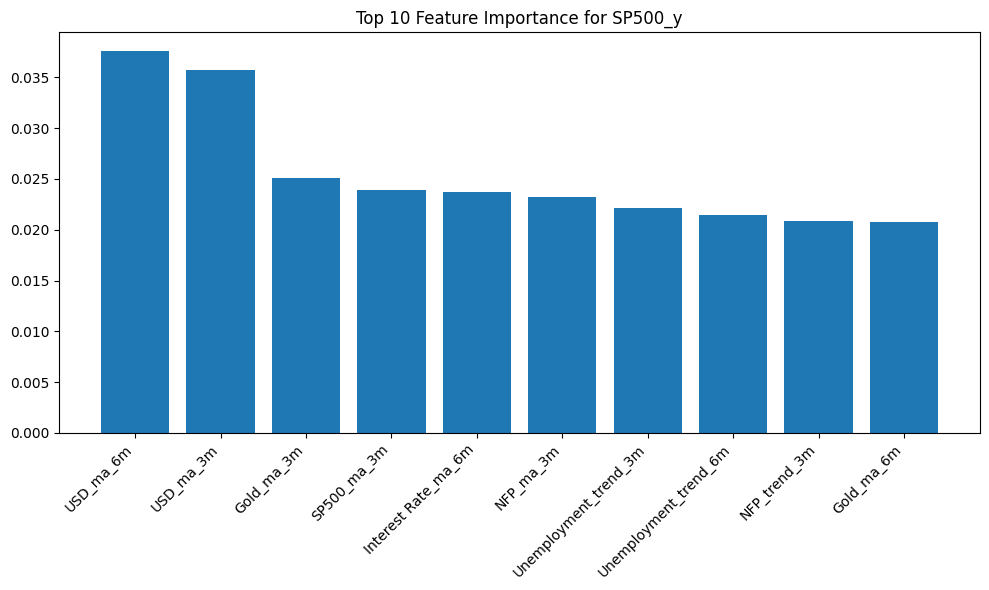


Training model for 10Y_Bond_y
Fold 1 Accuracy: 0.531
Fold 2 Accuracy: 0.562
Fold 3 Accuracy: 0.594
Fold 4 Accuracy: 0.500
Fold 5 Accuracy: 0.656
Average CV Accuracy: 0.569 (+/- 0.054)


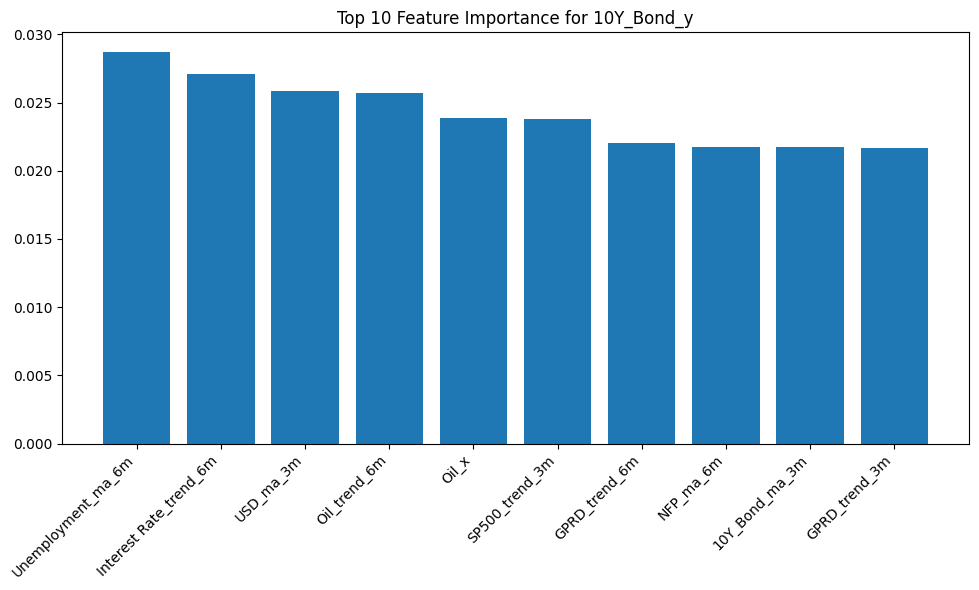


Training model for USD_y
Fold 1 Accuracy: 0.469
Fold 2 Accuracy: 0.562
Fold 3 Accuracy: 0.375
Fold 4 Accuracy: 0.531
Fold 5 Accuracy: 0.594
Average CV Accuracy: 0.506 (+/- 0.078)


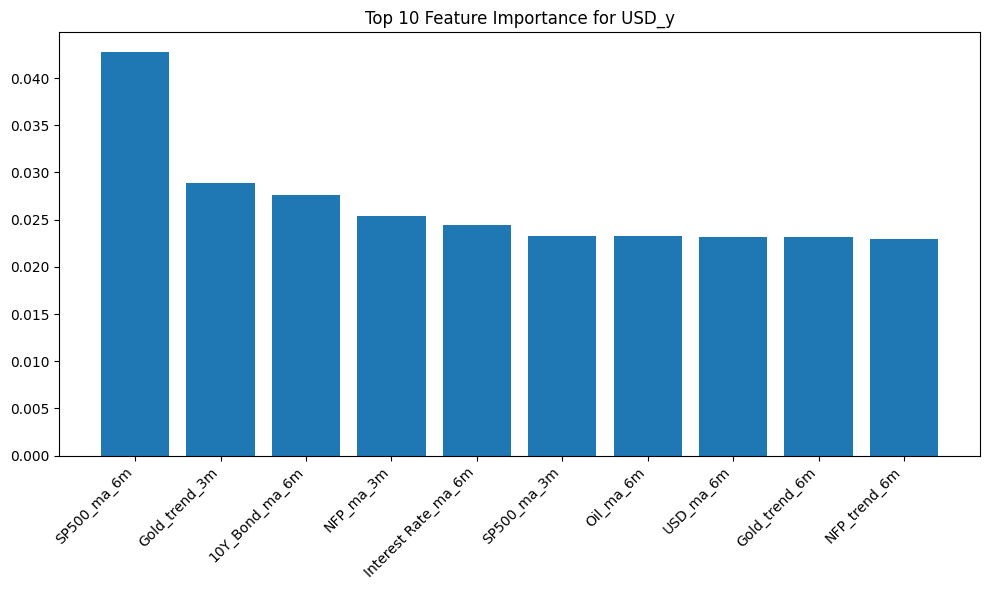


Training model for Gold_y
Fold 1 Accuracy: 0.469
Fold 2 Accuracy: 0.531
Fold 3 Accuracy: 0.594
Fold 4 Accuracy: 0.406
Fold 5 Accuracy: 0.500
Average CV Accuracy: 0.500 (+/- 0.062)


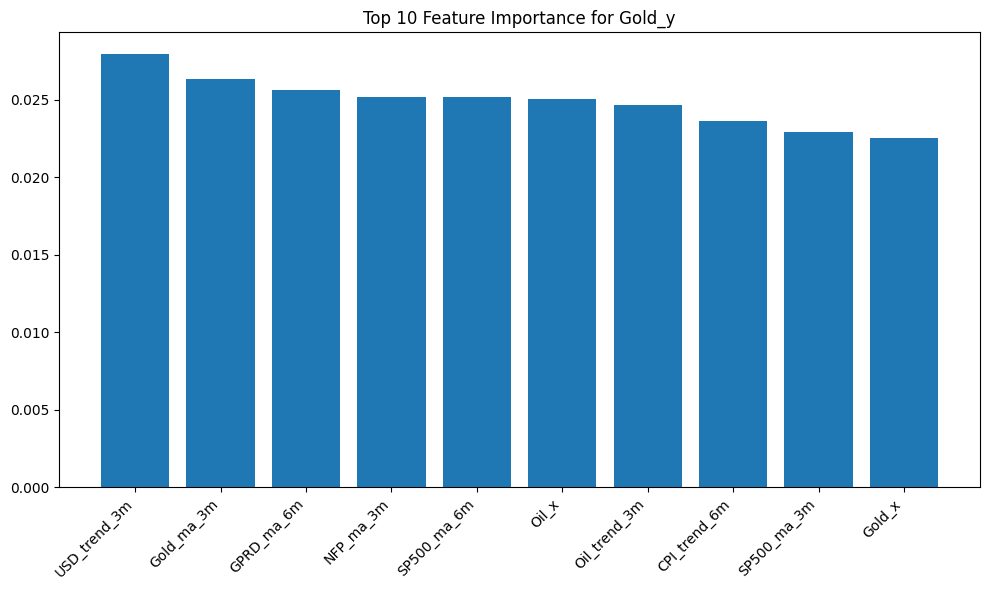


Training model for Oil_y
Fold 1 Accuracy: 0.531
Fold 2 Accuracy: 0.656


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

Fold 3 Accuracy: 0.562


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

Fold 4 Accuracy: 0.375
Fold 5 Accuracy: 0.469
Average CV Accuracy: 0.519 (+/- 0.094)


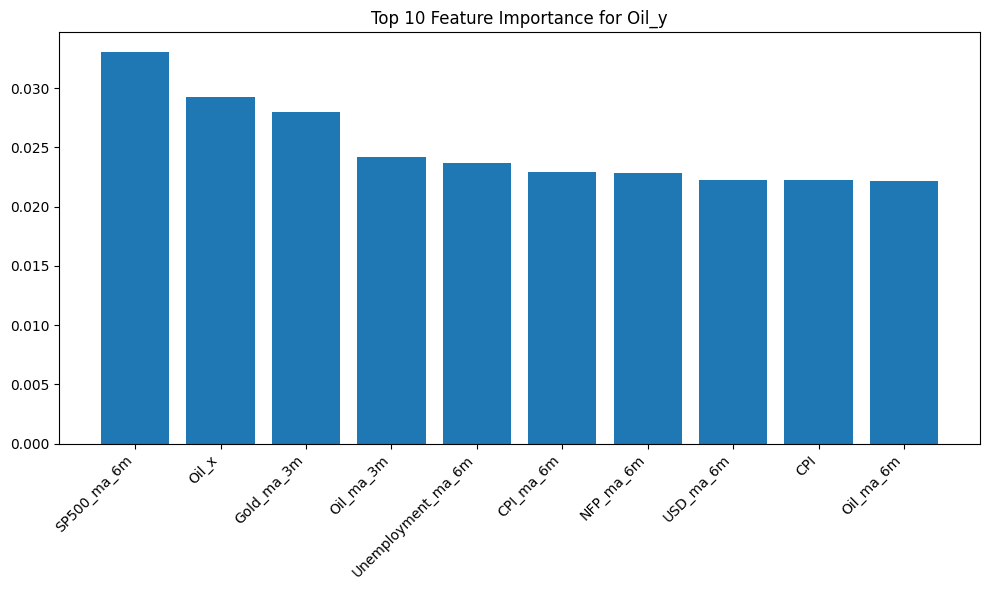

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11500\3137856932.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill')



Future Test Results for SP500_y:
              precision    recall  f1-score   support

         0.0       0.33      0.29      0.31        24
         1.0       0.67      0.71      0.69        48

    accuracy                           0.57        72
   macro avg       0.50      0.50      0.50        72
weighted avg       0.56      0.57      0.56        72



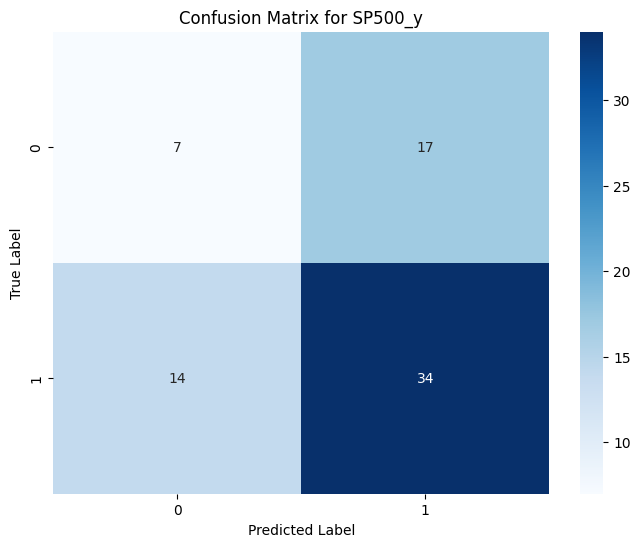


Future Test Results for 10Y_Bond_y:
              precision    recall  f1-score   support

         0.0       0.49      0.68      0.57        40
         1.0       0.24      0.12      0.16        32

    accuracy                           0.43        72
   macro avg       0.36      0.40      0.37        72
weighted avg       0.38      0.43      0.39        72



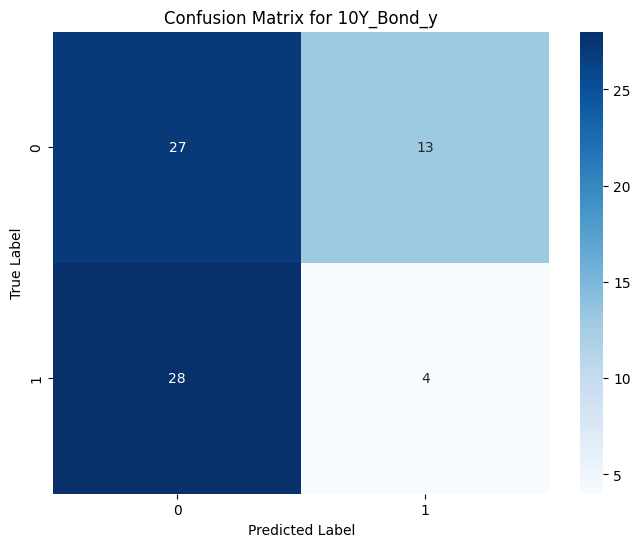


Future Test Results for USD_y:
              precision    recall  f1-score   support

         0.0       0.44      0.68      0.53        31
         1.0       0.58      0.34      0.43        41

    accuracy                           0.49        72
   macro avg       0.51      0.51      0.48        72
weighted avg       0.52      0.49      0.47        72



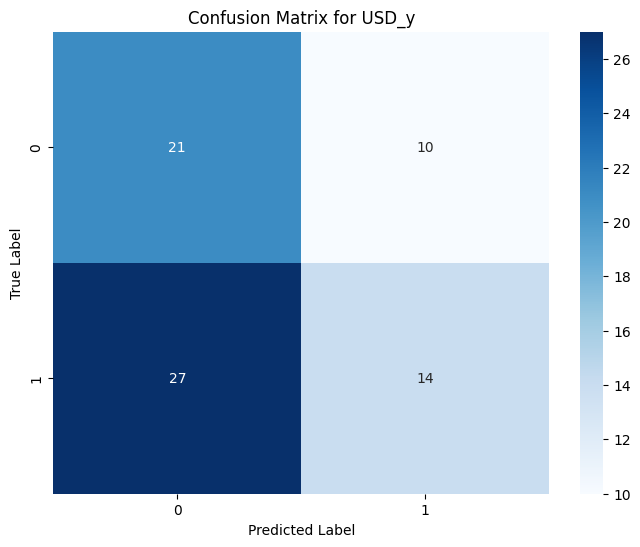


Future Test Results for Gold_y:
              precision    recall  f1-score   support

         0.0       0.44      0.81      0.57        32
         1.0       0.54      0.17      0.26        40

    accuracy                           0.46        72
   macro avg       0.49      0.49      0.42        72
weighted avg       0.50      0.46      0.40        72



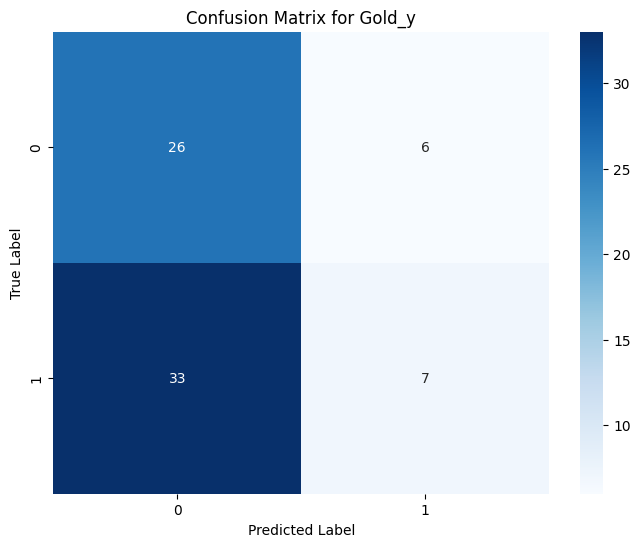


Future Test Results for Oil_y:
              precision    recall  f1-score   support

         0.0       0.50      0.61      0.55        31
         1.0       0.65      0.54      0.59        41

    accuracy                           0.57        72
   macro avg       0.57      0.57      0.57        72
weighted avg       0.58      0.57      0.57        72



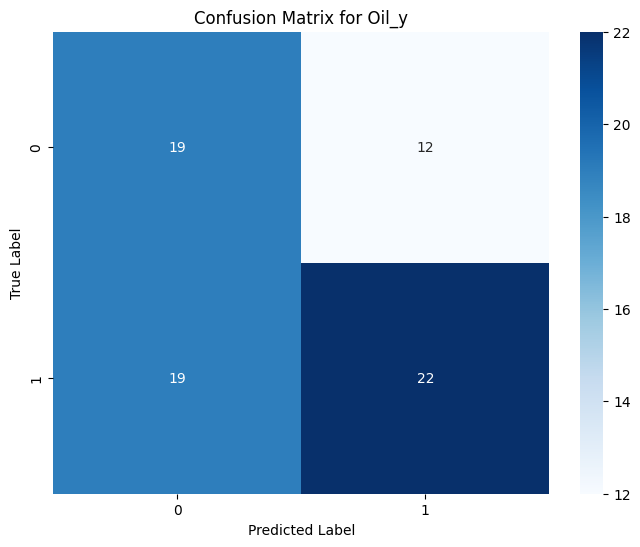

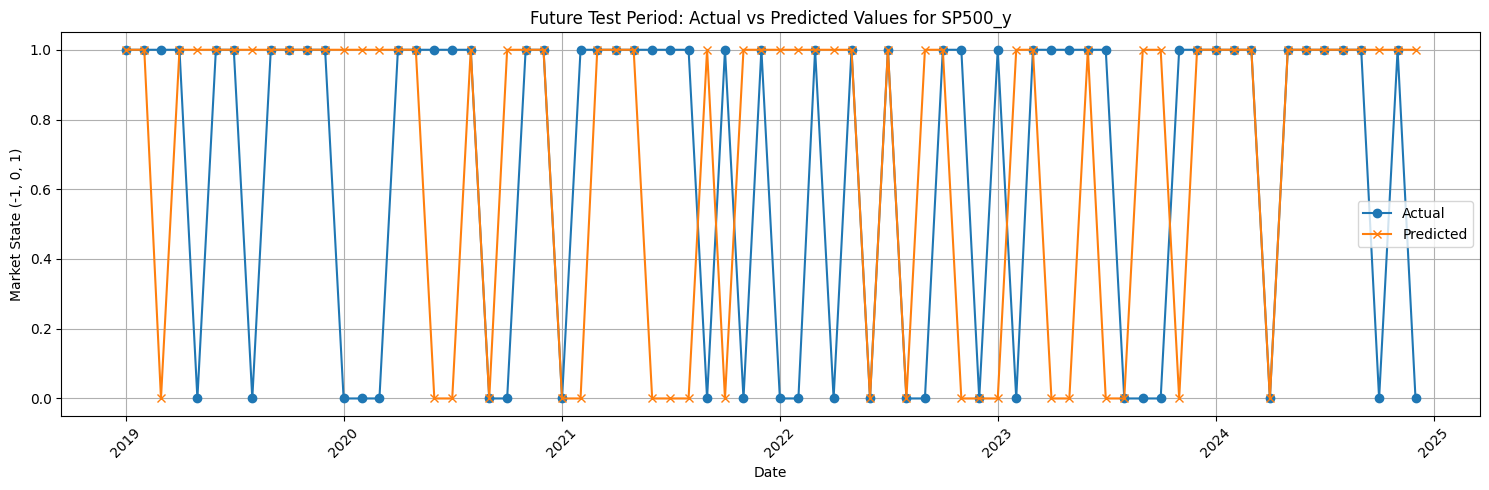

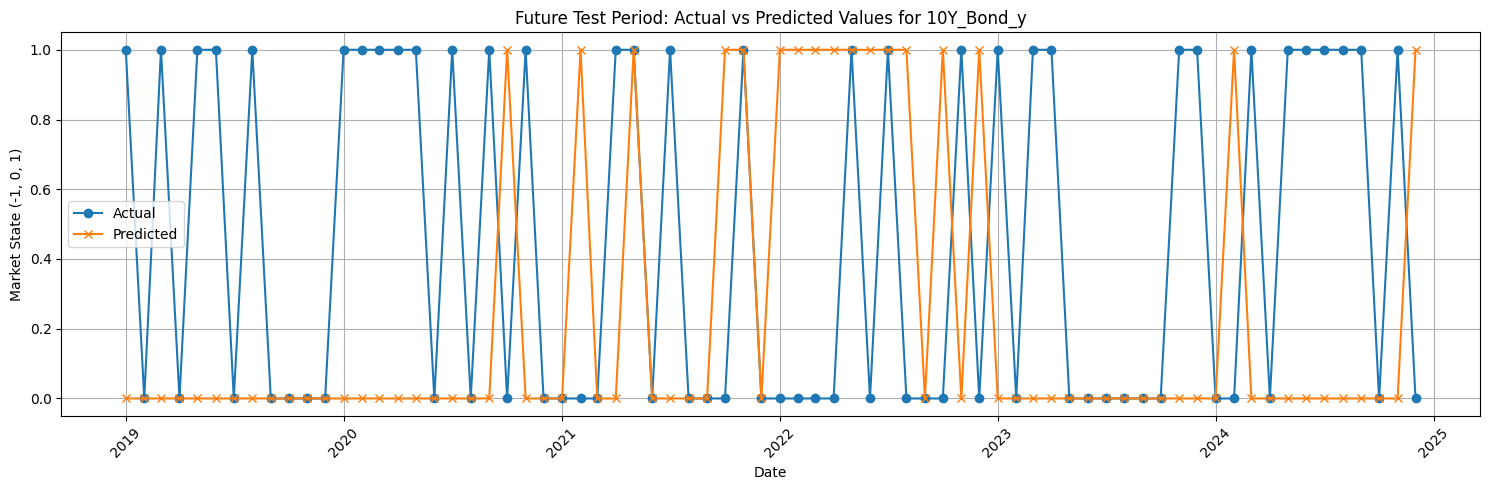

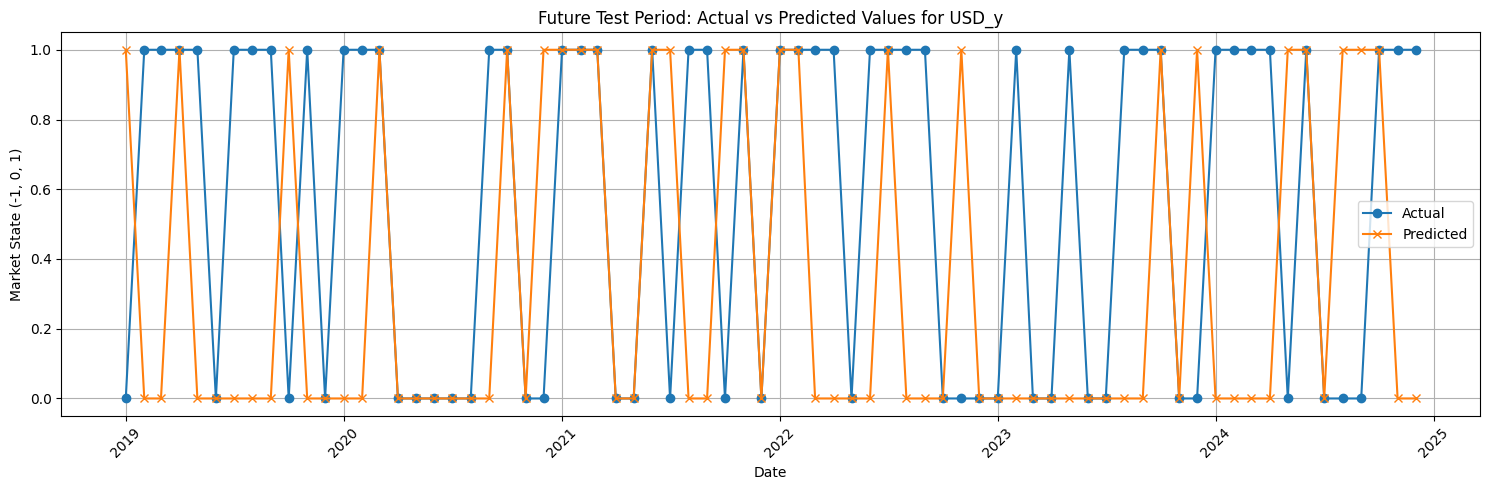

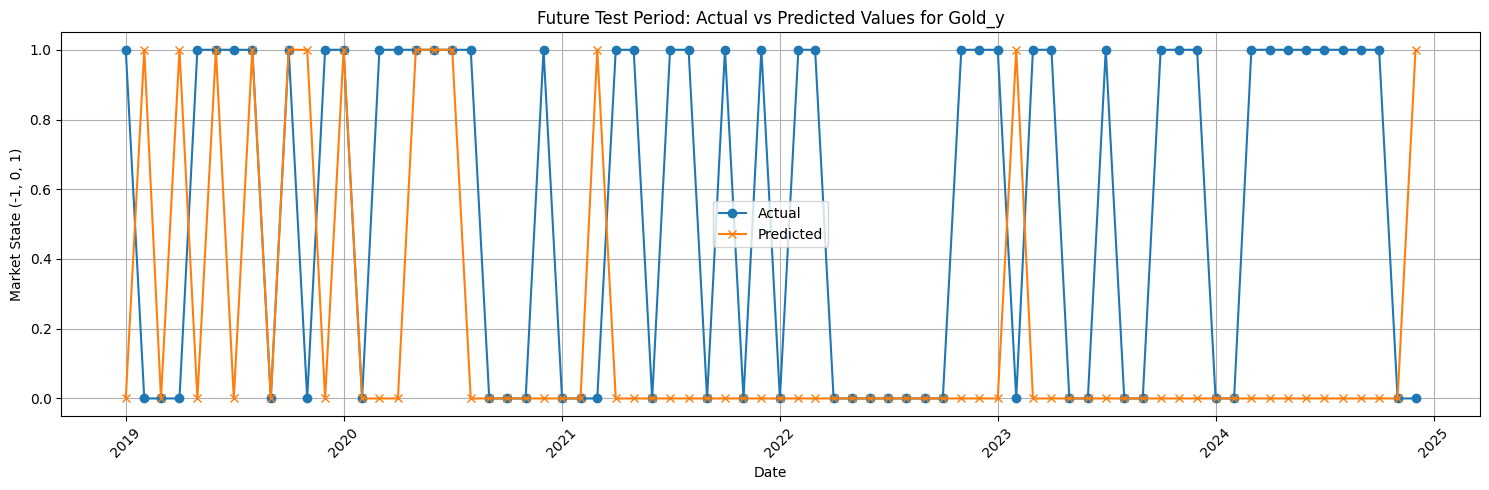

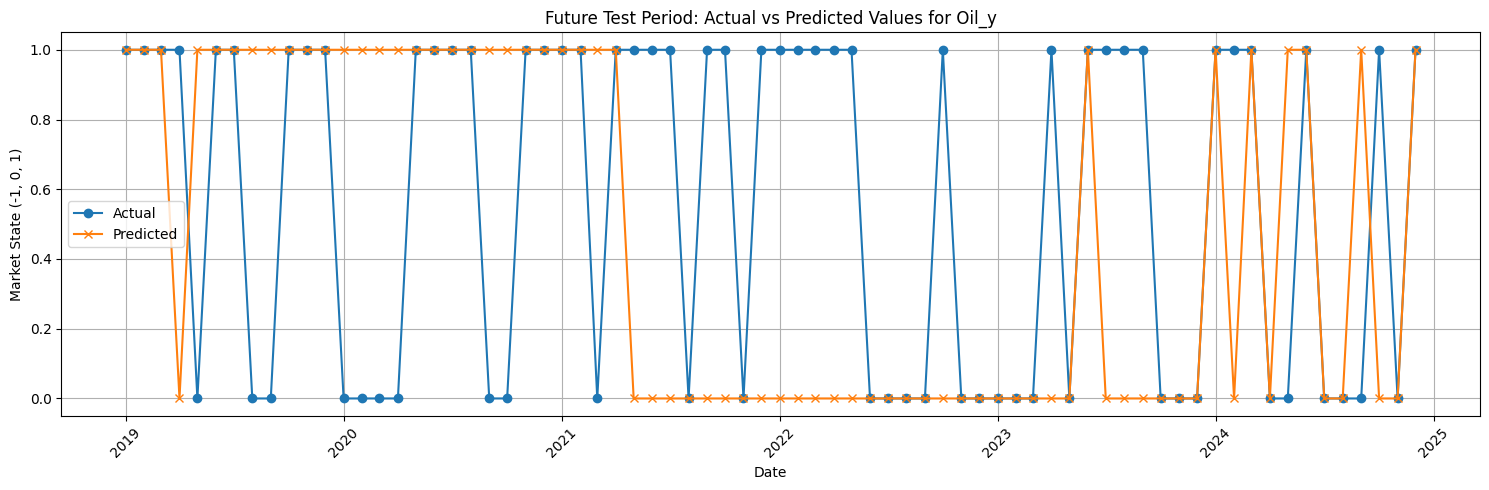

In [19]:
results, prices = train_model()

In [25]:
bt = trade(prices, "2019-01-01")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11500\2011803572.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  first_trading_days = orders.index.to_series().groupby(orders.index.to_period('M')).first()


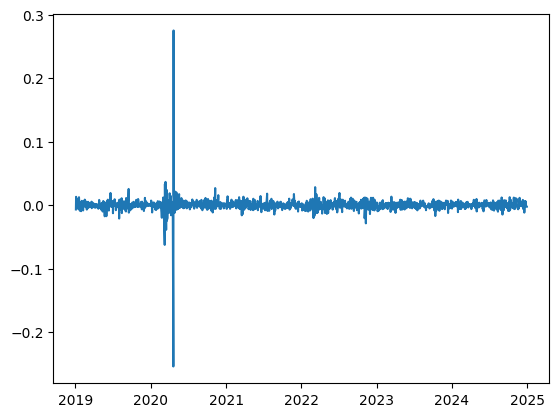

In [28]:
plt.plot(data.daily_returns)

In [29]:
bt.get_summary()

{'total_return': '0.00%', 'sharpe_ratio': '0.00', 'volatility': '1.15%'}